# Q Learning based on value function
We build a maze environment to train Q-learning model based on value function.

In [62]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

os.makedirs("frame", exist_ok=True)

In [61]:
# 动作符号
action_symbols = {
    0: '↑',  
    1: '↓',  
    2: '←',  
    3: '→',  
}

# 动作索引
actions = {
    0: (-1, 0),  # 上
    1: (1, 0),   # 下
    2: (0, -1),  # 左
    3: (0, 1)    # 右
}

# 迷宫环境设置
# maze = np.array([
#     [2, -1, -1, 1],
#     [0, -1, -1, 0],
#     [0, 0, 0, 0],
# ])
maze = np.array([
    [1,0,2],
    [0,0,0]
])
rows, cols = maze.shape
start, end = np.argwhere(maze==1)[0], np.argwhere(maze==2)[0]

In [35]:
def plot_policy_with_maze(Q_value_fn, maze_map, shape=(4, 4), show=False, title=None):
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(shape[1]+1)-0.5, minor=True)
    ax.set_yticks(np.arange(shape[0]+1)-0.5, minor=True)
    ax.grid(which="minor", color="black", linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

    if title is None:
        ax.set_title("Maze Policy")
    else:
        ax.set_title(title)

    for i in range(shape[0]):
        for j in range(shape[1]):
            if maze_map[i, j] == -1:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='gold'))
            else:
                if maze_map[i, j] == 0:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='skyblue'))
                elif maze_map[i, j] == 2:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='red'))
                else:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='green'))

                state = (i, j)
                q_values = [Q_value_fn(state, a) for a in range(4)]
                best_action = np.argmax(q_values)
                ax.text(j, i, action_symbols[best_action], ha='center', va='center', fontsize=20, color='black')

    plt.gca().invert_yaxis()
    if show:
        plt.show()
    return fig


def plot_q_values_with_maze(Q_value_fn, maze_map, shape=(4, 4)):
    max_q = np.zeros(shape)
    fig, ax = plt.subplots()
    ax.set_title("Max Q-Value per State with Maze")

    max_global_q = float('-inf')

    for i in range(shape[0]):
        for j in range(shape[1]):
            if maze_map[i, j] == -1:
                max_q[i, j] = 0
            else:
                q_values = [Q_value_fn((i, j), a) for a in range(4)]
                max_q[i, j] = max(q_values)
                max_global_q = max(max_global_q, max_q[i, j])

    for i in range(shape[0]):
        for j in range(shape[1]):
            if maze_map[i, j] == -1:
                color = 'gold'
            else:
                norm_val = max_q[i, j] / max_global_q if max_global_q > 0 else 0
                color = plt.cm.Blues(norm_val)
                ax.text(j, i, f"{max_q[i, j]:.2f}", ha='center', va='center', color='black')

            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color=color))

    ax.set_xticks(np.arange(shape[1]+1)-0.5, minor=True)
    ax.set_yticks(np.arange(shape[0]+1)-0.5, minor=True)
    ax.grid(which="minor", color="black", linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.gca().invert_yaxis()
    plt.show()


100%|██████████| 5000/5000 [00:02<00:00, 2093.75it/s]


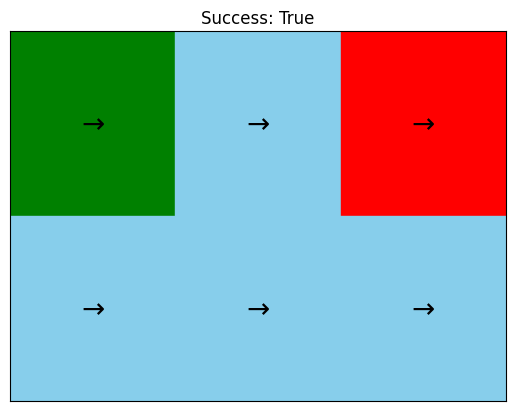

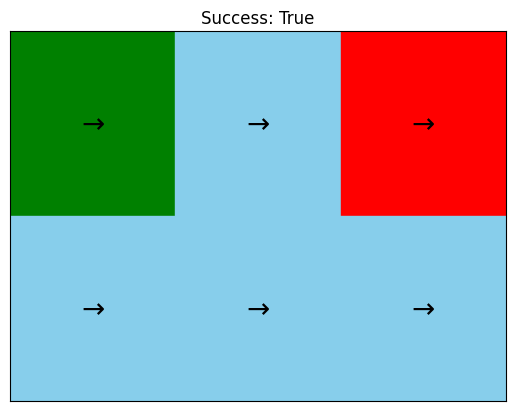

In [ ]:
# Q-Learning参数
alpha = 0.1   # 学习率
gamma = 0.9   # 折扣因子
epsilon = 0.1 # 探索概率

# Q table
def phi(state, action_index):
    feature = np.array((state[0]**2, state[1]**2, state[0]*state[1], state[0], state[1], 0, 0, 0, 0, 1))
    feature[5+action_index] = 1
    return feature

theta = np.zeros(len(phi([0,0],0)))

def Q_value(state, action_index):
    return np.dot(phi(state, action_index), theta)

# 训练过程
max_count = 40
success_episodes = []

for episode in tqdm(range(5000)):
    state = start
    count = 0
    success = False

    while not (state==end).all() and count < max_count:
        # ε-greedy 策略选择动作
        if np.random.rand() < epsilon:
            action_index = np.random.choice([0, 1, 2, 3])
        else:
            q_values = [Q_value(state, a) for a in range(4)]
            action_index = np.argmax(q_values)

        action = actions[action_index]
        next_state = (state[0] + action[0], state[1] + action[1])

        # 判断是否合法移动
        if 0 <= next_state[0] < rows and 0 <= next_state[1] < cols and maze[next_state[0], next_state[1]] != -1:
            reward = 1 if (next_state == end).all() else 0
            success = success or (next_state == end).all()
            
            next_q_values = [Q_value(next_state, a) for a in range(4)]
            target = reward + gamma * max(next_q_values)
        else:
            target = -1  # 非法移动惩罚
            next_state = state  # stay in place

        predict = Q_value(state, action_index)
        delta = target - predict

        theta += alpha * delta * phi(state, action_index)
        state = next_state
        count += 1
    
        if success:
            success_episodes.append(episode)
            # epsilon = 0.1  # 收敛后降低探索率


## Optional

In [ ]:
def Q_value_print():
    for a in range(4):
        print(f"Action index: {a}")
        for i in range(maze.shape[0]):
            print([Q_value([i, j], a).item() for j in range(maze.shape[1])])

Q_value_print()

Action index: 0
[-0.9999997604365302, 0.8348536577697865, 10.651069524740908]
[-0.8803056755114456, -1.201280063481215, 6.459107997313821]
Action index: 1
[-1.0678527275129344, 0.7670006906933822, 10.583216557664505]
[-0.9481586425878498, -1.2691330305576194, 6.391255030237417]
Action index: 2
[-1.012106932655366, 0.8227464855509505, 10.638962352522073]
[-0.8924128477302815, -1.213387235700051, 6.447000825094985]
Action index: 3
[-1.00828324494627, 0.8265701732600466, 10.642786040231169]
[-0.8885891600211854, -1.209563547990955, 6.450824512804081]


In [ ]:
# Visualize successful rollouts
plt.figure(figsize=(12, 4))
plt.scatter(success_episodes, [1]*len(success_episodes), marker='|', color='green')
plt.yticks([0, 1], ["Failure", "Success"])
plt.xlabel("Episode Index")
plt.title("Episode of successful arrival, reward=0 and epsilon=0.5")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

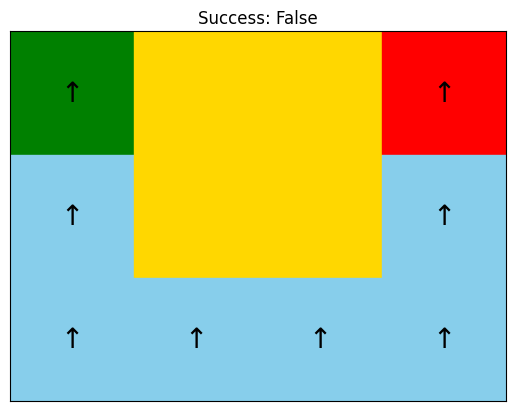

In [ ]:
# Visualize policy
fig = plot_policy_with_maze(Q_value, maze, maze.shape, show=True, title=f"Success: {success}")
fig.savefig(f"images.png")
plt.close(fig)

In [ ]:
# Visualize Q value
plot_q_values_with_maze(Q, maze, maze.shape)